In [1]:

import cartopy.feature as feature
import cartopy.crs as ccrs
from calendar import month_abbr
import matplotlib.dates as mdates
from pathlib import Path 
import subprocess 
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import datetime
import numpy as np
import pandas as pd
import xarray
import xesmf
import os 
from glob import glob
from plot_common import autoextend_colorbar, corners, get_map_norm, open_var, add_ticks, annotate_skill, save_figure
from scipy.stats import ttest_1samp
import statistics
import scipy 
import xgcm

In [2]:
rootmed1 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_1/gfdl.ncrc5-intel22-prod') 
rootlow1 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_1/gfdl.ncrc5-intel22-prod')
rootmed2 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_2/gfdl.ncrc5-intel22-prod') 
rootlow2 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_2/gfdl.ncrc5-intel22-prod')
rootmed3 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_3/gfdl.ncrc5-intel22-prod') 
rootlow3 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_3/gfdl.ncrc5-intel22-prod')
rootmed4 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_4/gfdl.ncrc5-intel22-prod') 
rootlow4 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_4/gfdl.ncrc5-intel22-prod')
rootmed5 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_5/gfdl.ncrc5-intel22-prod') 
rootlow5 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_5/gfdl.ncrc5-intel22-prod')

In [3]:
static = (
    xarray.open_dataset('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_1/gfdl.ncrc5-intel22-prod/pp/ocean_monthly/ocean_monthly.static.nc')
    .squeeze()
    .drop_vars('time', errors = 'ignore')
)
xgrid = xgcm.Grid(
    static,
    coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'},
    },
    metrics={
        ('X', ): ['dxt'],
        ('Y', ): ['dyt'], 
        ('X', 'Y'): ['areacello']
    },
    periodic=[],
    boundary='fill'
)

In [4]:
uolowens1 = open_var(rootlow1, 'ocean_daily', 'ssu') 
uvlowens1 = open_var(rootlow1, 'ocean_daily', 'ssv') 

In [5]:
uomedens1 = open_var(rootmed1, 'ocean_daily', 'ssu') 
uvmedens1 = open_var(rootmed1, 'ocean_daily', 'ssv') 

In [6]:
ave_ssu = uolowens1.sel(time=slice('1997', None)).mean('time').compute()
ave_ssv = uvlowens1.sel(time=slice('1997', None)).mean('time').compute()
uprime = xgrid.interp(uolowens1, 'X') - xgrid.interp(ave_ssu, 'X')
vprime = xgrid.interp(uvlowens1, 'Y') - xgrid.interp(ave_ssv, 'Y')
eke = np.power(uprime, 2) + np.power(vprime, 2)
# ^ then multiply above by rho/2 (1035 / 2)

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Da

In [7]:
nens = 5
ens_mean_dict = dict() 
for resolution in ['low', 'med']: 
    members = []
    for ens in range(1, nens+1):
        root_resolution = Path(f'/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_{resolution}atm_ens_{ens}/gfdl.ncrc5-intel22-prod/')
        ssu = open_var(root_resolution, 'ocean_daily', 'ssu').sel(time=slice('1997', None))
        ssv = open_var(root_resolution, 'ocean_daily', 'ssv').sel(time=slice('1997', None))
        ave_ssu = ssu.mean('time').compute()
        ave_ssv = ssv.mean('time').compute()
        uprime = xgrid.interp(ssu, 'X') - xgrid.interp(ave_ssu, 'X')
        vprime = xgrid.interp(ssv, 'Y') - xgrid.interp(ave_ssv, 'Y')
        eke = np.power(uprime, 2) + np.power(vprime, 2)
        members.append(eke) 
        print(str(ens) + " is done") 
    all_members = xarray.concat(members, dim='member')
    all_mean = all_members.mean(['time', 'member']) 
    ens_mean_dict.update({resolution: all_mean}) 

print(ens_mean_dict) 

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Da

1 is done


/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Da

2 is done


/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Da

3 is done


/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Da

4 is done


/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Da

5 is done


/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Da

1 is done


/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Da

2 is done


/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Da

3 is done


/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Da

4 is done
5 is done
{'low': <xarray.DataArray (yh: 845, xh: 775)> Size: 3MB
dask.array<mean_agg-aggregate, shape=(845, 775), dtype=float32, chunksize=(845, 775), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh       (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.88 51.9 51.91 51.93, 'med': <xarray.DataArray (yh: 845, xh: 775)> Size: 3MB
dask.array<mean_agg-aggregate, shape=(845, 775), dtype=float32, chunksize=(845, 775), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh       (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.88 51.9 51.91 51.93}


/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Da

In [8]:
loadlowmed = (ens_mean_dict['low']-ens_mean_dict['med']).load() 

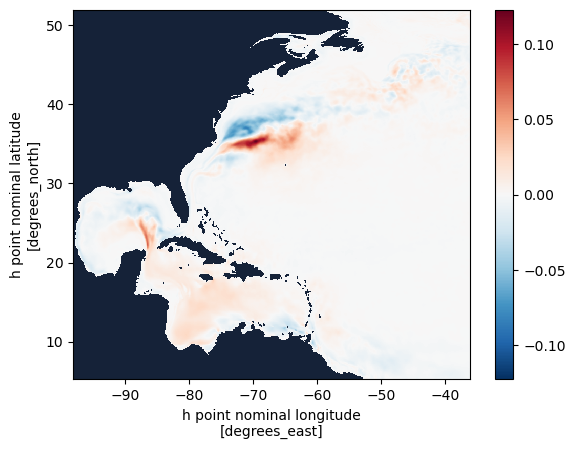

In [9]:
loadlowmed.plot() 
plt.gca().set_facecolor('#152238')


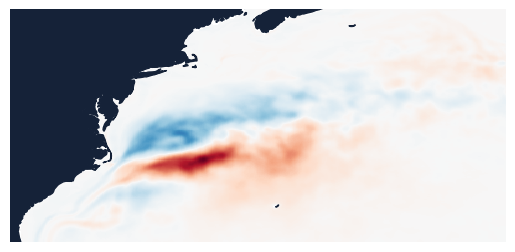

In [10]:
_LAND_50M = feature.NaturalEarthFeature(
    'physical', 'land', '50m',
    edgecolor='face',
    facecolor='#152238'
    )
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
loadlowmed.plot(ax=ax, add_colorbar=False)
ax.add_feature(_LAND_50M)
ax.set_extent([-82, -50, 30, 44])
ax.spines['geo'].set_visible(False)
plt.rcParams['figure.dpi'] = 1200
plt.show() 
